In [23]:
#Import all necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras import models, layers, optimizers
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import LSTM, Dropout, Dense

In [2]:
#Dara cleaning and preparation
df = pd.read_csv('combined_dataset.csv')
print(df.head())

  model    year  price transmission mileage fuelType    tax   mpg  engineSize  \
0    A1  2017.0  12500       Manual   15735   Petrol  150.0  55.4         1.4   
1    A6  2016.0  16500    Automatic   36203   Diesel   20.0  64.2         2.0   
2    A1  2016.0  11000       Manual   29946   Petrol   30.0  55.4         1.4   
3    A4  2017.0  16800    Automatic   25952   Diesel  145.0  67.3         2.0   
4    A3  2019.0  17300       Manual    1998   Petrol  145.0  49.6         1.0   

   tax(£) fuel type engine size mileage2 fuel type2 engine size2 reference  
0     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
1     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
2     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
3     NaN       NaN         NaN      NaN        NaN          NaN       NaN  
4     NaN       NaN         NaN      NaN        NaN          NaN       NaN  


C:\Users\hp\AppData\Local\Temp\ipykernel_15156\3900233614.py:2: DtypeWarning: Columns (2,4,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('combined_dataset.csv')


In [3]:
#Investigate columns in dataset
for column in df.columns:
    print(f"Unique values in column {column}:")
    print(df[column].unique())

Unique values in column model:
[' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7' ' 5 Series' ' 6 Series' ' 1 Series' ' 7 Series'
 ' 2 Series' ' 4 Series' ' X3' ' 3 Series' ' X5' ' X4' ' i3' ' X1' ' M4'
 ' X2' ' X6' ' 8 Series' ' Z4' ' X7' ' M5' ' i8' ' M2' ' M3' ' M6' ' Z3'
 ' C Class' ' Focus' ' Fiesta' ' Puma' ' Kuga' ' EcoSport' ' C-MAX'
 ' Mondeo' ' Ka+' ' Tourneo Custom' ' S-MAX' ' B-MAX' ' Edge'
 ' Tourneo Connect' ' Grand C-MAX' ' KA' ' Galaxy' ' Mustang'
 ' Grand Tourneo Connect' ' Fusion' ' Ranger' ' Streetka' ' Escort'
 ' Transit Tourneo' ' I20' ' Tucson' ' I10' ' IX35' ' I30' ' I40' ' Ioniq'
 ' Kona' ' Veloster' ' I800' ' IX20' ' Santa Fe' ' Accent' ' Terracan'
 ' Getz' ' Amica' ' SLK' ' S Class' ' SL CLASS' ' G Class' ' GLE Class'
 ' GLA Class' ' A Class' ' B Class' ' GLC Class' ' E Class' ' GL Class'
 ' CLS Class' ' CLC Class' ' CLA Class' ' V Class' ' M Clas

In [4]:
#Clear all duplicate rows
duplicate_rows = df.duplicated()
print(duplicate_rows.sum())
df = df.drop_duplicates()

2427


In [5]:
#Change the datatype of certain columns before combining
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['engineSize'] = pd.to_numeric(df['engineSize'], errors='coerce')
df['engine size2'] = pd.to_numeric(df['engine size2'], errors='coerce')
df['engine size'] = pd.to_numeric(df['engine size'], errors='coerce')
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')
df['mileage2'] = pd.to_numeric(df['mileage2'], errors='coerce')

In [6]:
#Combine similar columns
df['all_fuel type'] = df['fuelType'].fillna('') + df['fuel type'].fillna('') + df['fuel type2'].fillna('')
df['all_tax'] = df['tax'].fillna(0) + df['tax(£)'].fillna(0)
df['all_engineSize'] = df['engineSize'].fillna(0) + df['engine size2'].fillna(0) + df['engine size'].fillna(0)
df['all_mileage'] = df['mileage'].fillna(0) + df['mileage2'].fillna(0)

In [7]:
#Drop the original columns
df.drop(['fuelType', 'fuel type', 'fuel type2', 'tax', 'tax(£)', 'engineSize', 'engine size2', 'mileage', 'mileage2', 'engine size'], axis=1, inplace=True)

In [8]:
#Check for missing values after combining
missing_values = df.isnull().sum()
print("Missing values after combining columns:\n", missing_values)

Missing values after combining columns:
 model                  1
year                  93
price               9456
transmission           1
mpg                18011
reference         106268
all_fuel type          0
all_tax                0
all_engineSize         0
all_mileage            0
dtype: int64


In [9]:
#Check column datatypes
print("Column datatypes:\n", df.dtypes)
print(df.head())

Column datatypes:
 model              object
year              float64
price             float64
transmission       object
mpg               float64
reference          object
all_fuel type      object
all_tax           float64
all_engineSize    float64
all_mileage       float64
dtype: object
  model    year    price transmission   mpg reference all_fuel type  all_tax  \
0    A1  2017.0  12500.0       Manual  55.4       NaN        Petrol    150.0   
1    A6  2016.0  16500.0    Automatic  64.2       NaN        Diesel     20.0   
2    A1  2016.0  11000.0       Manual  55.4       NaN        Petrol     30.0   
3    A4  2017.0  16800.0    Automatic  67.3       NaN        Diesel    145.0   
4    A3  2019.0  17300.0       Manual  49.6       NaN        Petrol    145.0   

   all_engineSize  all_mileage  
0             1.4      15735.0  
1             2.0      36203.0  
2             1.4      29946.0  
3             2.0      25952.0  
4             1.0       1998.0  


In [10]:
#The use of the column 'reference' is unknown and it possesses too many missing values and will be dropped
df.drop(['reference'], axis=1, inplace=True)

In [11]:
#Fill missing values for numeric columns
df.fillna({'year': df['year'].median(),
           'price': df['price'].mean(),
           'mpg': df['mpg'].mean()}, inplace=True)

In [12]:
#Fill for categorical columns 
df.fillna({'model': df['model'].mode()[0],
           'transmission': df['transmission'].mode()[0]}, inplace=True)

In [13]:
#Verify if there are any remaining missing values
missing_values_after_imputation = df.isnull().sum()
print("Missing values after imputation:\n", missing_values_after_imputation)

Missing values after imputation:
 model             0
year              0
price             0
transmission      0
mpg               0
all_fuel type     0
all_tax           0
all_engineSize    0
all_mileage       0
dtype: int64


In [14]:
#encode and scale categorical and numerical columns

#Define columns
categorical_cols = ['model', 'transmission', 'all_fuel type']
numeric_cols = ['year', 'price', 'all_tax', 'all_engineSize', 'all_mileage', 'mpg']

#Categorical features
categorical_encoder = OneHotEncoder(sparse_output=False)
categorical_features = pd.DataFrame(categorical_encoder.fit_transform(df[categorical_cols]))

#Numerical features
numerical_scaler = StandardScaler()
numerical_features = pd.DataFrame(numerical_scaler.fit_transform(df[numeric_cols]))

#Combine features
df_encoded_scaled = pd.concat([categorical_features, numerical_features], axis=1)
print(df_encoded_scaled.head())
total_unique_values = df[categorical_cols].nunique().sum()
print(f"Total unique values across categorical features: {total_unique_values}")

#Encode target variable as one-hot
target = df['model']
target_encoded = pd.get_dummies(target).values

   0    1    2    3    4    5    6    7    8    9    ...  271  272  273  274  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   

        0         1         2         3         4         5    
0 -0.038878 -0.465541  0.667842 -0.093318 -0.263589  0.013073  
1 -0.506805 -0.038735 -1.120170 -0.089846  0.701172  0.604904  
2 -0.506805 -0.625593 -0.982631 -0.093318  0.406248  0.013073  
3 -0.038878 -0.006724  0.599072 -0.089846  0.217990  0.813390  
4  0.896974  0.046626  0.599072 -0.095633 -0.911084 -0.376998  

[5 rows x 281 columns]
Total unique values across categorical features: 275


In [15]:
#Begin the creation and training of the neural network
def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(0.001),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [16]:
#Split the data into train and test sets
X = df_encoded_scaled.to_numpy()
y = target_encoded

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [18]:
#Define the cross-validation procedure
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [19]:
#Perform k-fold cross-validation
cv_scores = []
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

In [26]:
#Train the model 
model = create_model(input_shape=X_train.shape[1], num_classes=y_train.shape[1])
final_history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_val_fold, y_val_fold))
# Evaluate the model
val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=1)
cv_scores.append(val_acc)
    
print("Cross-Validation Accuracy: %.2f%% (%.2f%%)" % (np.mean(cv_scores)*100, np.std(cv_scores)*100))

Epoch 1/20
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2820 - loss: 3.2745 - val_accuracy: 0.8747 - val_loss: 0.7540
Epoch 2/20
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6893 - loss: 1.1472 - val_accuracy: 0.9591 - val_loss: 0.3138
Epoch 3/20
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7591 - loss: 0.8302 - val_accuracy: 0.9751 - val_loss: 0.1892
Epoch 4/20
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7934 - loss: 0.6900 - val_accuracy: 0.9878 - val_loss: 0.1317
Epoch 5/20
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8159 - loss: 0.6070 - val_accuracy: 0.9925 - val_loss: 0.0989
Epoch 6/20
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8342 - loss: 0.5411 - val_accuracy: 0.9944 - val_loss: 0.0743
Epoch 7/20
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8489 - loss: 0.4856 - val_accuracy: 0.9960 - val_loss: 0.0587
Epoch 8/20
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8612 - loss: 0.4467 - 

In [27]:
#Evaluate the final model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

1447/1447 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9986 - loss: 0.0334
Test Accuracy: 0.9987


In [20]:
#Plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

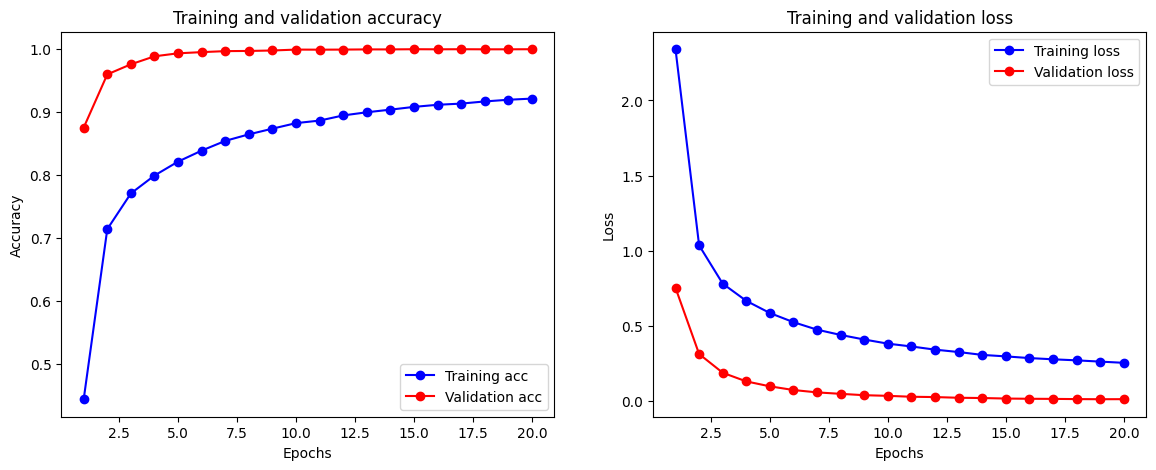

In [29]:
plot_history(final_history)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3140 - loss: 3.2583 - val_accuracy: 0.9590 - val_loss: 0.4175
Epoch 2/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9502 - loss: 0.4041 - val_accuracy: 0.9918 - val_loss: 0.0960
Epoch 3/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9849 - loss: 0.1406 - val_accuracy: 0.9967 - val_loss: 0.0347
Epoch 4/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9924 - loss: 0.0704 - val_accuracy: 0.9984 - val_loss: 0.0160
Epoch 5/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9952 - loss: 0.0440 - val_accuracy: 0.9990 - val_loss: 0.0093
Epoch 6/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9966 - loss: 0.0301 - val_accuracy: 0.9993 - val_loss: 0.0064
Epoch 7/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9974 - loss: 0.0228 - val_accuracy: 0.9994 - val_loss: 0.0051
Epoch 8/10
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9978 - loss: 0.0186 -

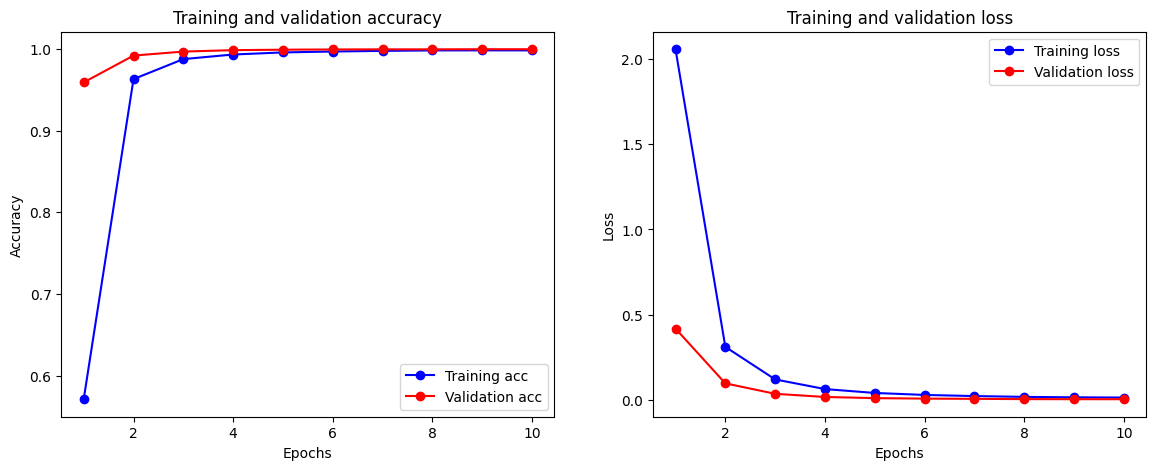

In [21]:
"""LSTM model"""
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(32, input_shape=(input_shape[1], input_shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(0.001),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Reshape the data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_val_lstm = X_val_fold.reshape(X_val_fold.shape[0], 1, X_val_fold.shape[1])

# Create and train the LSTM model
lstm_model = create_lstm_model(input_shape=X_train_lstm.shape, num_classes=y_train.shape[1])
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_val_lstm, y_val_fold))

# Evaluate the LSTM model
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"LSTM Model Accuracy: {lstm_acc:.4f}")

# Plot LSTM accuracy and loss curves
plot_history(lstm_history)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5267 - loss: 2.4238 - val_accuracy: 0.9938 - val_loss: 0.0750
Epoch 2/5
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9932 - loss: 0.0719 - val_accuracy: 0.9991 - val_loss: 0.0123
Epoch 3/5
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9984 - loss: 0.0185 - val_accuracy: 0.9996 - val_loss: 0.0041
Epoch 4/5
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9994 - loss: 0.0064 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 5/5
2170/2170 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9994 - loss: 0.0041 - val_accuracy: 0.9999 - val_loss: 0.0013
1447/1447 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9995 - loss: 0.0043
Bidirectional LSTM Model Accuracy: 0.9994


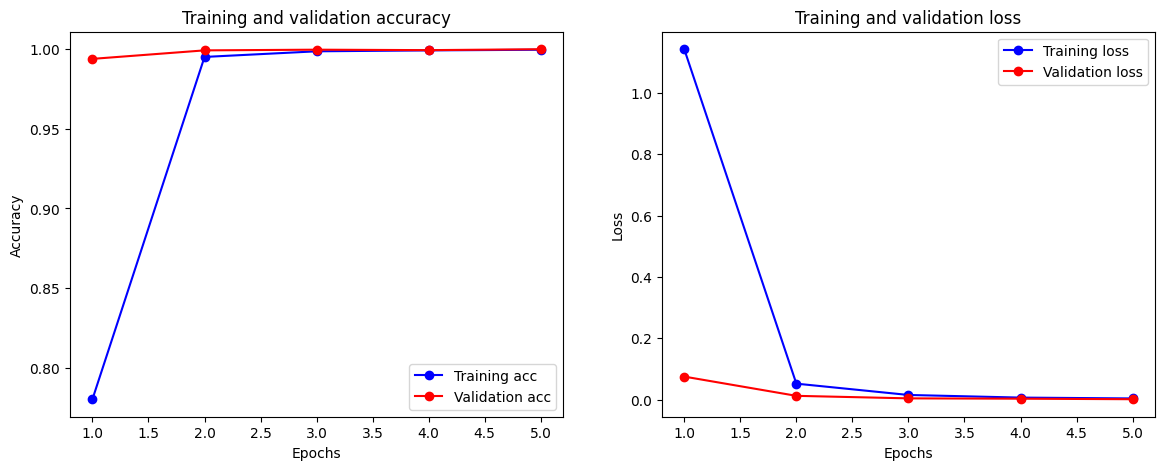

In [24]:
def create_bidirectional_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(input_shape[1], input_shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(0.001),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Reshape the data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Assuming that the validation data needs to be reshaped similarly
X_val_lstm = X_val_fold.reshape(X_val_fold.shape[0], 1, X_val_fold.shape[1])

# Create and train the Bidirectional LSTM model
bidirectional_lstm_model = create_bidirectional_lstm_model(input_shape=X_train_lstm.shape, num_classes=y_train.shape[1])
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, verbose=1, validation_data=(X_val_lstm, y_val_fold))

# Evaluate the Bidirectional LSTM model
bidirectional_lstm_loss, bidirectional_lstm_acc = bidirectional_lstm_model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"Bidirectional LSTM Model Accuracy: {bidirectional_lstm_acc:.4f}")

# Plot Bidirectional LSTM accuracy and loss curves
plot_history(bidirectional_lstm_history)